Author: Jeremiasz Hauck

In [1]:
%reload_ext autoreload
%autoreload 2

# use either of the two
# use '%matplotlib notebook' if interactive plots are needed
#%matplotlib notebook 
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import copy

In this notebook elements of a 2D graphics pipeline are presented.
The following procedures have been implemented:

 * 2D transformations: translating, rotating and scaling
 
 * line drawing - Bresenham's algorithm
 
 * poligon drawing
 
 * poligon filling - my own algorithm
 
 * poligon clipping - Sutherland-Hodgman algorithm
 
 * line clipping - Cohen-Sutherland algorithm
 
 * windowing transformation
 
The procedures combined together would form a 2D graphics pipeline.

The images are represented as numpy matrices with dimension height x width x 3 and displayed using matplotlib.

In [3]:
# canvas has shape 3 x height x width
#     where the '3' represents the number of color channels

def show(canvas, figsize=None):
    if figsize:
        fig, axs = plt.subplots(1, 1, figsize=figsize)
    else:
        fig, axs = plt.subplots(1, 1)
    axs.imshow(canvas.astype(np.uint8))
    
def show2(canvas1, canvas2, figsize=None):
    if figsize:
        fig, axs = plt.subplots(1, 2, figsize=figsize)
    else:
        fig, axs = plt.subplots(1, 2)
    axs[0].imshow(canvas1.astype(np.uint8))
    axs[1].imshow(canvas2.astype(np.uint8))

2D transformations follow a standard practice where there is a stack on which a transformation matrix can be pushed or popped from.

In [4]:
# 2D transformations
# there is one global transformation matrix that is 
#     used for all transformations
# any canvas operations with transformations applied 
#     should be preceeded with push_matrix() and ended with pop_matrix()

matrix_stack = []
trns_mat = np.eye(3)

def push_matrix():
    global trns_mat
    matrix_stack.append(trns_mat)
    trns_mat = np.eye(3)

def pop_matrix():
    global trns_mat
    trns_mat = matrix_stack.pop()
    
def translate(vec):
    global trns_mat
    t = np.array([[1, 0, vec[0]], [0, 1, vec[1]], [0, 0, 1]])
    trns_mat = trns_mat.dot(t)
        
def rotate(angle):
    global trns_mat
    cos, sin = np.cos(angle), np.sin(angle)
    r = np.array([[cos, -sin, 0], [sin, cos, 0], [0, 0, 1]])
    trns_mat = trns_mat.dot(r)
        
def scale(sx, sy):
    global trns_mat
    s = np.array([[sx, 0, 0], [0, sy, 0], [0, 0, 1]])
    trns_mat = trns_mat.dot(s)

In [5]:
# utility class used in different settings

class Edge:
    def __init__(self, v1, v2, trns_mat):
        # first transform the vertices using the transformation matrix
        # transform the cartesian coordinates to homogeneous coordinates 
        v1 = trns_mat.dot(np.array([v1[0], v1[1], 1]))
        v2 = trns_mat.dot(np.array([v2[0], v2[1], 1]))
        
        # v1 vertex is the one that has a smaller x coordinate among the two
        if v2[0] < v1[0]:
            tmp = v2
            v2 = v1
            v1 = tmp
        self.v1 = v1
        self.v2 = v2

        # scan converting the vertices coordinates
        self.x1 = np.floor(v1[0] + 0.5).astype(np.int64)
        self.y1 = np.floor(v1[1] + 0.5).astype(np.int64)
        x2 = np.floor(v2[0] + 0.5).astype(np.int64)
        y2 = np.floor(v2[1] + 0.5).astype(np.int64)

        # line slope increments for Bresenham's Line Algorithm
        self.dx = x2 - self.x1
        dy = y2 - self.y1

        self.x = 0
        self.y = 0

        # is the line going down
        cond1 = dy < 0
        dy = abs(dy)
        # is the line slope not between -45° and 45°
        # note self.dx and dy are always positive
        cond2 = self.dx < dy

        # the same algorithm is used for all types of lines
        # there are four types depending on the inclination
        
        # type 1 -> inclination between 0° and 45°
        #           cond1 = False and cond2 = False
        
        # type 2 -> inclination between 45° and 90°
        #           cond1 = False and cond2 = True
        
        # type 3 -> inclination between -45° and 0°
        #           cond1 = True and cond2 = False
        
        # type 4 -> inclination between -90° and -45°
        #           cond1 = True and cond2 = True
        
        # if cond2 is true we relabel the axis
        #     treat the x axis as the y axis and vice versa
        if cond2:
            # relabel the axes slope increments
            tmp = self.dx
            self.dx = dy
            dy = tmp
            self.calc_x = lambda: self.x1 + self.y
            # if cond1 is true we simply subtract the increment
            if cond1:
                self.calc_y = lambda: self.y1 - self.x
            else:
                self.calc_y = lambda: self.y1 + self.x
        else:
            self.calc_x = lambda: self.x1 + self.x
            if cond1:
                self.calc_y = lambda: self.y1 - self.y
            else:
                self.calc_y = lambda: self.y1 + self.y

        self.d0 = 2 * dy - self.dx
        self.dT = 2 * (dy - self.dx)
        self.dS = 2 * dy

        self.x = 0
        self.y = 0
        self.d = self.d0
        self.last_x = self.calc_x()
        self.last_y = self.calc_y()

    # used for filling the polygon with color
    # one step of Bresenham's Line Algorithm
    def step_x(self):
        while self.x < self.dx:
            self.x += 1
            if self.d < 0:
                self.d += self.dS
            else:
                self.y += 1
                self.d += self.dT
                
            new_x = self.calc_x()
            new_y = self.calc_y()
            if new_x != self.last_x:
                self.last_x = new_x
                self.last_y = new_y
                return True
        return False

    # Bresenham's Line Algorithm
    def draw(self, canvas, color):
        while self.x <= self.dx:
            canvas[self.calc_y(), self.calc_x()] = color
            self.x += 1
            if self.d < 0:
                self.d += self.dS
            else:
                self.y += 1
                self.d += self.dT

In [6]:
def draw_line(canvas, v1, v2, color, trns_mat):
    edge = Edge(v1, v2, trns_mat)
    edge.draw(canvas, color)

Below is an example for visual inspection if the draw_line procedure functions properly.
All lines start at the same center point but all have different inclinations.

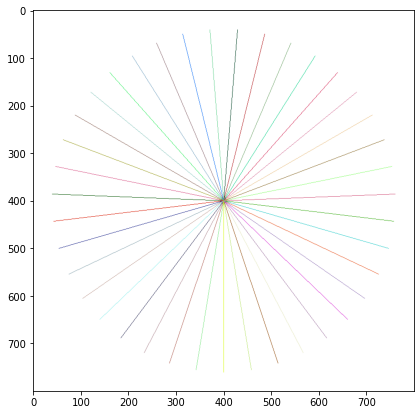

In [7]:
# initialize a white canvas
window_h, window_w = 800, 800
canvas1 = np.ones((window_h, window_w, 3)) * 255

np.random.seed(5)

y, x = window_h // 2, window_w // 2
pts1 = (y, x)
vec_len = 360.0
for angle in np.linspace(0, 2 * np.pi, 40):
    pts2 = (y + vec_len * np.sin(angle), x + vec_len * np.cos(angle))
    color = np.random.randint(0, 255, (3,))
    draw_line(canvas1, pts1, pts2, color, trns_mat)
    
show(canvas1, figsize=(7, 7))

In [8]:
def draw_poligon(canvas, vertices, color, trns_mat):
    edges = []
    for v1, v2 in zip(vertices[:-1], vertices[1:]):
        edges.append(Edge(v1, v2, trns_mat))
    edges.append(Edge(vertices[-1], vertices[0], trns_mat))
    
    for edge in edges:
        edge.draw(canvas, color)

In [9]:
def fill_poligon(canvas, vertices, color, trns_mat):
    edges = []
    for v1, v2 in zip(vertices[:-1], vertices[1:]):
        edges.append(Edge(v1, v2, trns_mat))
    edges.append(Edge(vertices[-1], vertices[0], trns_mat))
    edges.sort(key=lambda edge: edge.x1)
    
    def edges_gen(edges):
        for edge in edges:
            yield edge
        while True:
            yield None
            
    active_edges = []
    edges = edges_gen(edges)
    top = next(edges)
    x = top.x1
    
    # scan x from x_min to x_max
    # edge is an active edge if the x is within 
    #     the range that the edges x coordinates span
    while active_edges or top:
        # put all edges whose vertices with smaller x coordinate
        #     are equal to current x
        while top and top.x1 == x:
            active_edges.append(top)
            top = next(edges)

        # make one step of the Bresenham's Line Algorithm
        #     and check if the edges in the active_edges list
        #     are still active after making this one step
        x += 1
        active_edges = [edge for edge in active_edges if edge.step_x()]

        # fill the vertical space between consecutive pairs of active edges
        active_edges.sort(key=lambda edge: edge.last_y)
        for e1, e2 in zip(active_edges[:-1:2], active_edges[1::2]):
            canvas[e1.last_y+1:e2.last_y, x] = color

Below is an example for visual inspection if the draw_polygon and fill_polygon procedures function properly.
On the left you can see the case where fill_polygon procedure has been used, on the right the case where draw_polygon has been used. Those images show also the effect of applying 2D transformations. All drawn triangles have the same vertices, it is the different transformations (translate, rotate, scale) that are applied to the triangles that make them look different.

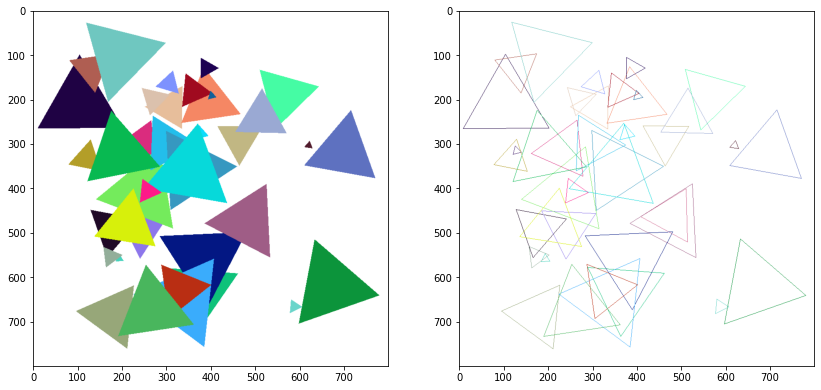

In [10]:
a = 200
h = a * np.sqrt(3) / 6
vertices = [(0, 2 * h), (-a / 2, -h), (a / 2, -h)]

# initialize a white canvas
window_h, window_w = 800, 800
canvas2 = np.ones((window_h, window_w, 3)) * 255
canvas3 = np.ones((window_h, window_w, 3)) * 255

np.random.seed(5)

# paint random triangles on the canvas with random
#     transformations and colors
N = 40
x, y = window_w // 2, window_h // 2
for _ in range(N):
    push_matrix()
    translate((x + np.random.randint(-300, 300),
               y + np.random.randint(-300, 300)))
    rotate(np.random.rand() * np.pi * 2)
    s = max(0.1, np.random.rand())
    scale(s, s)
    color = np.random.randint(0, 255, (3,))
    fill_poligon(canvas2, vertices, color, trns_mat)
    draw_poligon(canvas3, vertices, color, trns_mat)
    pop_matrix()
    
show2(canvas2, canvas3, figsize=(14, 7))

In [11]:
# split the line between v1 and v2 with the line between a and b
# return vertex output list for Sutherland-Hodgman Algorithm
def split(v1, v2, a, b):
    # this formula is a negated version of the original version
    # this is because the y axis is oriented downwards
    c = lambda xy: ((b[1] - a[1]) * (xy[0] - a[0]) - 
                    (b[0] - a[0]) * (xy[1] - a[1]))
    
    # check on which side do the vertices fall of the line ab
    c1 = c(v1)
    c2 = c(v2)
    
    # usefull values for calculating the interseciton point of two lines
    # formulas come from transforming the following equation:
    
    # ((v2_y - v1_y) / (v2_x - v1_x)) * x + v1_y = 
    #     ((b_y - a_y) / (b_x - a_x)) * x + a_y and solving for x
    
    # and calculating y from ((v2_y - v1_y) / (v2_x - v1_x)) * x + v1_y
    #     with x coming from previous equation
    
    aa = ((v2[1] - v1[1]) * (b[0] - a[0]) * v1[0] - 
          (v2[0] - v1[0]) * (b[1] - a[1]) * a[0] + 
          (v2[0] - v1[0]) * (b[0] - a[0]) * (a[1] - v1[1]))
    
    bb = ((v2[1] - v1[1]) * (b[0] - a[0]) - 
          (v2[0] - v1[0]) * (b[1] - a[1]))
    
    cc = ((v2[0] - v1[0]) * (b[1] - a[1]) * v1[1] - 
          (v2[1] - v1[1]) * (b[0] - a[0]) * a[1] + 
          (v2[1] - v1[1]) * (b[1] - a[1]) * (a[0] - v1[0]))
    
    # vertex output list for Sutherland-Hodgman Algorithm
    # only for the two lines v1-v2 a-b
    v = []
    
    if c2 >= 0: # v2 is to the left of the edge a-b
        # v1 is to the right of the edge a-b
        #     and v2 is not on the edge a-b
        if c1 < 0 and c2 > 0:
            # append intersection point
            v.append((aa / bb, cc / -bb))
        v.append(v2)
    elif c1 >= 0: # v1 is to the left of the edge a-b
        # append the intersection point
        v.append((aa / bb, cc / -bb))
    return v

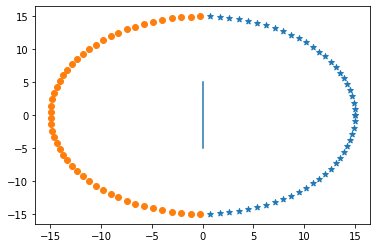

In [12]:
# this cell runs the formula that checks if 
#     a point falls on the left or right of a line
# different points are tried out that form a circle
# those that are labaled with a blue star are to the left of the line
# those that are labeled with a orange circle are to the right of the line

#x1, y1, x2, y2 = (-5, -5, 5, 5)
#x1, y1, x2, y2 = (-5, 5, 5, -5)
#x1, y1, x2, y2 = (-5, 0, 5, 0)
#x1, y1, x2, y2 = (0, -5, 0, 5)
x1, y1, x2, y2 = (0, 5, 0, -5)

xs = np.linspace(x1, x2, 100)
ys = np.linspace(y1, y2, 100)
theta = np.linspace(0, 2 * np.pi, 100)
x = 15 * np.cos(theta)
y = 15 * np.sin(theta)
c = ((x2 - x1) * (y - y1) - (y2 - y1) * (x - x1))
c_p = c >= 0
c_n = c < 0
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(xs, ys)
ax.scatter(x[c_p], y[c_p], marker='*')
ax.scatter(x[c_n], y[c_n])

In [13]:
# test some obvious input cases for split function
split((0, 0), (0, 10), (-5, 5), (5, 5))

[(0.0, 5.0)]

In [14]:
# test some obvious input cases for split function
split((0, 10), (0, 0), (-5, 5), (5, 5))

[(-0.0, 5.0), (0, 0)]

In [15]:
# test some obvious input cases for split function
split((100, 100), (400, 100), (200, 200), (200, 600))

[(200.0, 100.0), (400, 100)]

In [16]:
# Sutherland-Hodgman Algorithm
def clip_poligon(vertices, clip_vertices):
    v = [] # vertex output list
    # clipp every edge of the poligon with every edge of the clipping polygon
    # every time all edges are clipped by the clipping polygon a new polygon arises
    # this new poligon is then clipped by the clipping polygon until
    #     all clipping polygon edges have been used up for clipping
    for cv1, cv2 in zip(clip_vertices[:-1], clip_vertices[1:]):
        if vertices:
            for v1, v2 in zip(vertices[:-1], vertices[1:]):
                v.extend(split(v1, v2, cv1, cv2))
            v1, v2 = vertices[-1], vertices[0]
            v.extend(split(v1, v2, cv1, cv2))
            vertices = v
            v = []
            
    if not vertices:
        return vertices
    cv1, cv2 = clip_vertices[-1], clip_vertices[0]
    for v1, v2 in zip(vertices[:-1], vertices[1:]):
        v.extend(split(v1, v2, cv1, cv2))
    v1, v2 = vertices[-1], vertices[0]
    v.extend(split(v1, v2, cv1, cv2))
    return v

In [17]:
# simple example of clip_poligon
clip_vertices = [(200, 200), (200, 600), (600, 600), (600, 200)]
vv = [(100, 100), (100, 400), (400, 400), (400, 100)]
new_v = clip_poligon(vv, clip_vertices)
new_v

[(200.0, 200.0), (200.0, 400.0), (400, 400), (400.0, 200.0)]

Below is an example for visual inspection if the clip_polygon procedure functions properly.
On the left the image has unclipped polygons. On the right the image has clipped polygons by a square polygon.

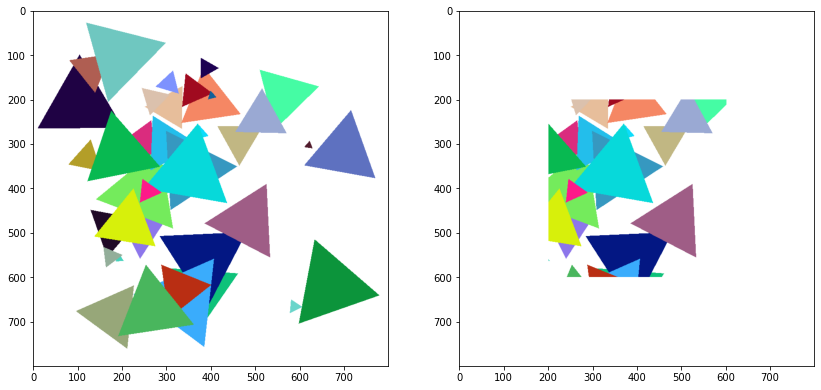

In [18]:
canvas4 = np.ones((window_h, window_w, 3)) * 255
canvas5 = np.ones((window_h, window_w, 3)) * 255

np.random.seed(5)

# paint random triangles on the canvas with random
#     transformations and colors
# this time clip the polygons with a clipping polygon
N = 40
x, y = window_w // 2, window_h // 2
for _ in range(N):
    push_matrix()
    translate((x + np.random.randint(-300, 300),
               y + np.random.randint(-300, 300)))
    rotate(np.random.rand() * np.pi * 2)
    s = max(0.1, np.random.rand())
    scale(s, s)
    color = np.random.randint(0, 255, (3,))
    fill_poligon(canvas4, vertices, color, trns_mat)
    
    # the clipping has to be applied affter the transformations
    v = []
    for vertex in vertices:
        vertex += (1,)
        vertex = trns_mat.dot(vertex)
        v.append((vertex[0], vertex[1]))
    pop_matrix()
    
    new_vertices = clip_poligon(v, clip_vertices)
    if not new_vertices:
        continue
    fill_poligon(canvas5, new_vertices, color, trns_mat)
    
show2(canvas4, canvas5, figsize=(14, 7))

In [19]:
# Cohen-Sutherland line clipping algorithm
def clip_line(v1, v2, clip_vertices):
    x_min = min(clip_vertices[0][0], clip_vertices[1][0],
                clip_vertices[2][0], clip_vertices[3][0])
    
    x_max = max(clip_vertices[0][0], clip_vertices[1][0],
                clip_vertices[2][0], clip_vertices[3][0])
    
    y_min = min(clip_vertices[0][1], clip_vertices[1][1],
                clip_vertices[2][1], clip_vertices[3][1])
    
    y_max = max(clip_vertices[0][1], clip_vertices[1][1],
                clip_vertices[2][1], clip_vertices[3][1])
    
    dx = (v2[0] - v1[0])
    dy = (v2[1] - v1[1])
    
    def region_code(v):
        return (1 if v[1] - y_max > 0 else 0,
                1 if y_min - v[1] > 0 else 0,
                1 if v[0] - x_max > 0 else 0,
                1 if x_min - v[0] > 0 else 0)
    
    def visible(code):
        return all(map(lambda x: x==0, code))
        
    def not_visible(code1, code2):
        return any(map(lambda x1, x2: x1&x2!=0, code1, code2))
    
    def intersect(code, v):
        if code[0] == 1:
            return (v[0] + (y_max - v[1]) * dx / dy, y_max)
        elif code[1] == 1:
            return (v[0] + (y_min - v[1]) * dx / dy, y_min)
        elif code[2] == 1:
            return (x_max, v[1] + (x_max - v[0]) * dy / dx)
        elif code[3] == 1:
            return (x_min, v[1] + (x_min - v[0]) * dy / dx)
        return None
        
    code1 = region_code(v1)
    code2 = region_code(v2)
    visible1 = visible(code1)
    visible2 = visible(code2)
    
    # finish if both vertices are not visible in the clipping bounds
    #     or if both are visible
    while not (not_visible(code1, code2) or (visible1 and visible2)):
        if not visible1:
            v1 = intersect(code1, v1)
            code1 = region_code(v1)
            visible1 = visible(code1)
        if not visible2:
            v2 = intersect(code2, v2)
            code2 = region_code(v2)
            visible2 = visible(code2)
        
    if not_visible(code1, code2):
        return None
    else:
        return v1, v2

In [20]:
# simple example of clip_line
clip_vertices = [(200, 200), (200, 600), (600, 600), (600, 200)]
# horizontal line
clip_line((100, 300), (700, 300), clip_vertices)

((200, 300.0), (600, 300.0))

In [21]:
# vertical line
clip_line((300, 100), (300, 700), clip_vertices)

((300.0, 200), (300.0, 600))

In [22]:
clip_line((250, 700), (550, 100), clip_vertices), clip_line((550, 100), (250, 700), clip_vertices)

(((300.0, 600), (500.0, 200)), ((500.0, 200), (300.0, 600)))

Below is an example for visual inspection if the clip_line procedure functions properly.
On the left the image has unclipped lines with different inclinations. On the right the image has the same lines clipped by a square polygon.

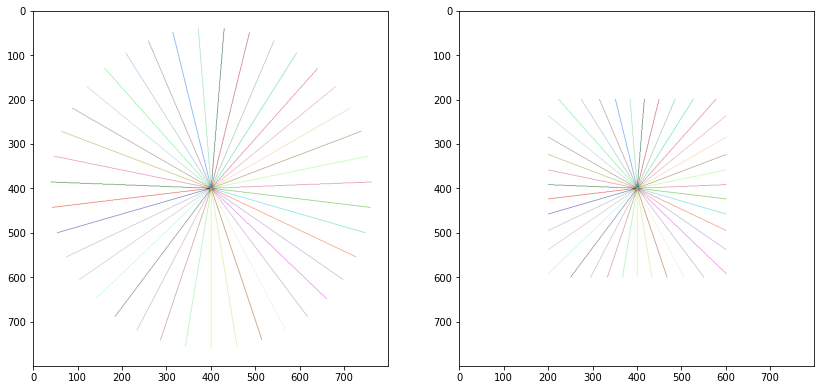

In [23]:
canvas6 = np.ones((window_h, window_w, 3)) * 255
canvas7 = np.ones((window_h, window_w, 3)) * 255

np.random.seed(5)

y, x = window_h // 2, window_w // 2
pts1 = (y, x)
vec_len = 360.0
for angle in np.linspace(0, 2 * np.pi, 40):
    pts2 = (y + vec_len * np.sin(angle), x + vec_len * np.cos(angle))
    color = np.random.randint(0, 255, (3,))
    p1, p2 = clip_line(pts1, pts2, clip_vertices)
    draw_line(canvas6, pts1, pts2, color, trns_mat)
    draw_line(canvas7, p1, p2, color, trns_mat)
    
show2(canvas6, canvas7, figsize=(14, 7))

Below is an example for visual inspection how windowing transformation works.
On the three images below are shown: on the left the world with a polygon expressed in worlds coordinates and a window also expressed in worlds coordinates, in the middle a mapped window to viewport with viewport having the same aspect ratio as the window, on the right a mapped window to viewport with viewport having a different aspect ratio then the window. The third image shows what happens when the window and viewport have different aspect ratios, the scene from the window is stretched.

Text(0.5, 1.0, 'Viewport 2')

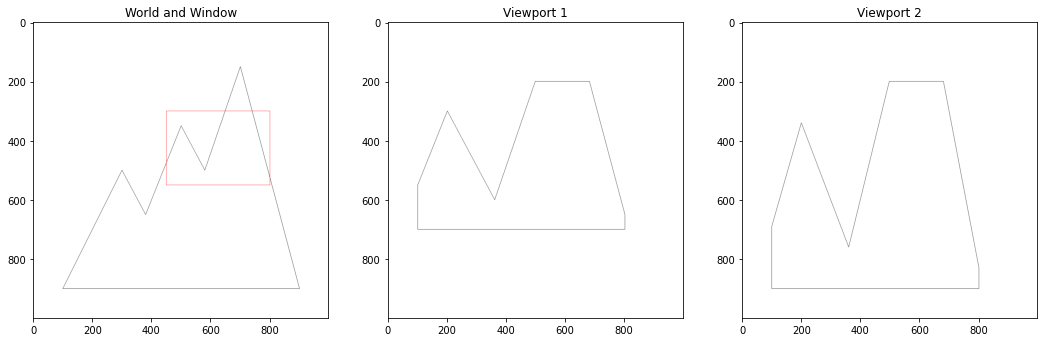

In [24]:
# window-to-viewport mapping
world = np.ones((1000, 1000, 3)) * 255
mountain = [(300, 500), (380, 650), (500, 350), 
            (580, 500), (700, 150), (900, 900), 
            (100, 900)]

# first make the world canvas with a window
#     that we want to display in the viewport
wx_min = 450
wx_max = 800
wy_min = 300
wy_max = 550
window = [(wx_min, wy_min), (wx_min, wy_max), 
          (wx_max, wy_max), (wx_max, wy_min)]

draw_poligon(world, mountain, np.array([0, 0, 0]), trns_mat)
draw_poligon(world, window, np.array([255, 0, 0]), trns_mat)

scene = clip_poligon(mountain, window)

# the first viewport has shape proportional to the window shape
v1x_min = 100
v1x_max = 800
v1y_min = 200
v1y_max = 700
viewport1 = np.ones((1000, 1000, 3)) * 255
# translate-scale-translate transformation
N1 = (np.array([[1, 0, v1x_min], [0, 1, v1y_min], [0, 0, 1]]) @
      np.array([[(v1x_max - v1x_min) / (wx_max - wx_min), 0, 0], 
                [0, (v1y_max - v1y_min) / (wy_max - wy_min), 0], 
                [0, 0, 1]]) @
      np.array([[1, 0, -wx_min], [0, 1, -wy_min], [0, 0, 1]]))

# add extra dimenion to make the coordinates homogeneous
#     and then multiply the coordinates of the vertices
#     by the translate-scale-translate transformation matrix
v1_coords = N1 @ np.hstack([np.array(scene), 
                            np.ones((len(scene), 1))]).transpose()
# strip the last dimension, the extra homogeneous coordinate
v1_coords = v1_coords.transpose()[:, :2]
draw_poligon(viewport1, v1_coords, np.array([0, 0, 0]), trns_mat)

# the second viewport has shape not proportional to the window shape
#     after window-to-viewport mapping the clipped poligon will be
#     distorted - stretched
v2x_min = 100
v2x_max = 800
v2y_min = 200
v2y_max = 900
viewport2 = np.ones((1000, 1000, 3)) * 255
N2 = (np.array([[1, 0, v2x_min], [0, 1, v2y_min], [0, 0, 1]]) @
      np.array([[(v2x_max - v2x_min) / (wx_max - wx_min), 0, 0], 
                [0, (v2y_max - v2y_min) / (wy_max - wy_min), 0], 
                [0, 0, 1]]) @
      np.array([[1, 0, -wx_min], [0, 1, -wy_min], [0, 0, 1]]))

v2_coords = N2 @ np.hstack([np.array(scene), np.ones((len(scene), 1))]).transpose()
v2_coords = v2_coords.transpose()[:, :2]
draw_poligon(viewport2, v2_coords, np.array([0, 0, 0]), trns_mat)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(world.astype(np.uint8))
axs[0].set_title('World and Window')
axs[1].imshow(viewport1.astype(np.uint8))
axs[1].set_title('Viewport 1')
axs[2].imshow(viewport2.astype(np.uint8))
axs[2].set_title('Viewport 2')